### 1. Load packages

In [1]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score

import random, torch
from SpaceFlow import SpaceFlow 

import WEST_plt

file_path = '/home/stat/cai/WEST/data/simulation/circle_grid_disp_0.2/'

/home/stat/anaconda3/envs/gcn2/lib/python3.8/site-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: libcudart.so.10.2: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/stat/anaconda3/envs/gcn2/lib/python3.8/site-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: libcudart.so.10.2: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/stat/anaconda3/envs/WEST/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, g

### 2. Load data

In [2]:
#### Read data from pickle
with open(file_path+'raw_data.pkl', 'rb') as file:
    adata = pickle.load(file)

### 3. Preprocess

In [3]:
sc.pp.normalize_total(adata, target_sum=1e4) # Normalization
sc.pp.log1p(adata) # Take log
sc.pp.highly_variable_genes(adata, n_top_genes=1000, subset=True) # Gene screening
sc.pp.pca(adata, n_comps=50) # PCA
sc.pp.neighbors(adata, n_neighbors=100) # use PCA as default

r_seed=t_seed=n_seed=1234
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)

adata.obsm['spatial'] = adata.obs[['loc_x', 'loc_y']].to_numpy()

# preprocess
sf = SpaceFlow.SpaceFlow(count_matrix=adata.X, spatial_locs=adata.obsm['spatial'])
sf.adata_preprocessed = adata
sf.spatial_graph = sf.graph_alpha(adata.obsm['spatial'], n_neighbors=50)

/home/stat/anaconda3/envs/gcn2/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


### 4. Model training

In [4]:
%%capture captured_output
# train
sf.train(spatial_regularization_strength=0.1, 
         z_dim=50, 
         lr=1e-3, 
         epochs=1000, 
         max_patience=50, 
         min_stop=100, 
         random_seed=42, 
         gpu=0, 
         regularization_acceleration=True, 
         edge_subset_sz=1000000)

# get new embedding
SpaceFlow_embedding = sf.embedding

### 4. Clustering

In [7]:
sf.segmentation(domain_label_save_filepath="./domains1.tsv", 
                n_neighbors=50, 
                resolution=0.3)

est_label = np.array(sf.domains).astype(int)
adata.obs["SpaceFlow"] = est_label
adata.obs["SpaceFlow"] = adata.obs["SpaceFlow"].astype("category")

ARI = adjusted_rand_score(adata.obs["SpaceFlow"], adata.obs["true cluster"])
print("ARI: ", ARI)
print(adata.obs["SpaceFlow"].unique())

Performing domain segmentation
Segmentation complete, domain labels of cells or spots saved at ./domains1.tsv !
ARI:  0.5312847043343434
[0, 3, 2, 1]
Categories (4, int64): [0, 1, 2, 3]


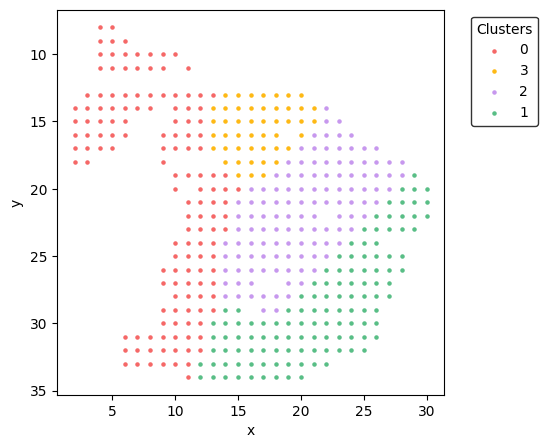

In [8]:
WEST_plt.WEST_scatter(adata, reps='SpaceFlow', invert_y=True, s=5)

### 5. Save embedding

In [9]:
np.savetxt(file_path+'SpaceFlow_embedding.csv',SpaceFlow_embedding, delimiter=',')
np.savetxt(file_path+'SpaceFlow_cluster.csv', adata.obs['SpaceFlow'], delimiter=',', fmt='%s')